In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
pd.set_option('mode.chained_assignment', None)

In [2]:
TIME_STEPS = 288
EPOCHS=50
BATCH_SIZE=128
PATIENCE=5
NUM_FEATURES = 1
RANDOM_SEED = 42

keras.utils.set_random_seed(RANDOM_SEED)

In [3]:
df_monday = pd.read_csv('data/art_monday.csv', parse_dates=True,
                        index_col="timestamp")
df_tuesday = pd.read_csv('data/art_tuesday.csv', parse_dates=True,
                         index_col="timestamp")
df_wednesday = pd.read_csv('data/art_wednesday.csv', parse_dates=True,
                           index_col="timestamp")
df_thursday = pd.read_csv('data/art_thursday.csv', parse_dates=True,
                          index_col="timestamp")
df_friday = pd.read_csv('data/art_friday.csv', parse_dates=True,
                        index_col="timestamp")
df_saturday = pd.read_csv('data/art_saturday.csv', parse_dates=True,
                          index_col="timestamp")
df_sunday = pd.read_csv('data/art_sunday.csv', parse_dates=True,
                        index_col="timestamp")

df_week = pd.read_csv('data/art_normal_week.csv', parse_dates=True,
                      index_col="timestamp")
df_anomaly_week = pd.read_csv('data/art_anomaly_week.csv', parse_dates=True,
                              index_col="timestamp")
df_three_month = pd.read_csv('data/art_three_month.csv', parse_dates=True,
                        index_col="timestamp")

In [4]:
df_test_monday = pd.read_csv('data/art_monday.csv', parse_dates=True,
                             index_col="timestamp")
df_test_monday['value'][2880:3168] = df_anomaly_week['value'][0:288]
df_test_tuesday = pd.read_csv('data/art_tuesday.csv', parse_dates=True,
                              index_col="timestamp")
df_test_tuesday['value'][2880:3168] = df_anomaly_week['value'][288:576]
df_test_wednesday = pd.read_csv('data/art_wednesday.csv', parse_dates=True,
                                index_col="timestamp")
df_test_wednesday['value'][2880:3168] = df_anomaly_week['value'][576:864]
df_test_thursday = pd.read_csv('data/art_thursday.csv', parse_dates=True,
                               index_col="timestamp")
df_test_thursday['value'][2880:3168] = df_anomaly_week['value'][864:1152]
df_test_friday = pd.read_csv('data/art_friday.csv', parse_dates=True,
                             index_col="timestamp")
df_test_friday['value'][2880:3168] = df_anomaly_week['value'][1152:1440]
df_test_saturday = pd.read_csv('data/art_saturday.csv', parse_dates=True,
                               index_col="timestamp")
df_test_saturday['value'][2880:3168] = df_anomaly_week['value'][1440:1728]
df_test_sunday = pd.read_csv('data/art_sunday.csv', parse_dates=True,
                             index_col="timestamp")
df_test_sunday['value'][2880:3168] = df_anomaly_week['value'][1728:2016]
df_test_three_month = pd.read_csv('data/art_three_month.csv', parse_dates=True,
                        index_col="timestamp")

df_test_three_month['value'][20160:22176] = df_anomaly_week['value'][:]

In [5]:
def plot_df(df):
  fig, ax = plt.subplots()
  df.plot(legend=False, ax=ax)
  plt.show()

In [6]:
def create_sequences(values):
    sequences = []
    for i in range(len(values) - TIME_STEPS + 1):
        sequences.append(values[i : (i + TIME_STEPS)])
    return np.stack(sequences)

In [7]:
def create_autoencoder():
  autoencoder = keras.Sequential(
      [
          layers.Input(shape=(TIME_STEPS, NUM_FEATURES)),
          layers.Conv1D(
              filters=32,
              kernel_size=7,
              padding="same",
              strides=2,
              activation="relu",
          ),
          layers.Dropout(rate=0.2),
          layers.Conv1D(
              filters=16,
              kernel_size=7,
              padding="same",
              strides=2,
              activation="relu",
          ),
          layers.Conv1DTranspose(
              filters=16,
              kernel_size=7,
              padding="same",
              strides=2,
              activation="relu",
          ),
          layers.Dropout(rate=0.2),
          layers.Conv1DTranspose(
              filters=32,
              kernel_size=7,
              padding="same",
              strides=2,
              activation="relu",
          ),
          layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
      ]
  )
  autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss="mse")
  autoencoder.summary()
  return autoencoder

In [8]:
def plot_loss(history):
  plt.plot(history.history["loss"], label="Training Loss")
  plt.plot(history.history["val_loss"], label="Validation Loss")
  plt.legend()
  plt.show()

In [9]:
def plot_mae_loss(mae_loss):
  plt.hist(mae_loss, bins=50)
  plt.xlabel("MAE loss")
  plt.ylabel("No of samples")
  plt.show()

In [10]:
def plot_reconstruction(x_train, x_train_pred):
  plt.plot(x_train[0])
  plt.plot(x_train_pred[0])
  plt.show()

In [11]:
def plot_anomalies(df_test_day, df_subset):
  fig, ax = plt.subplots()
  df_test_day.plot(legend=False, ax=ax)
  df_subset.plot(legend=False, ax=ax, color="r")
  plt.show()

In [12]:
def get_indices(seq_anomalies, size):
  indices = []
  for i in range(TIME_STEPS - 1, size - TIME_STEPS + 1):
      if np.all(seq_anomalies[i - TIME_STEPS + 1 : i]):
          indices.append(i)
  return indices

In [13]:
def find_anomalies(df_day, df_test_day, model_name):
  training_mean = df_day.mean()
  training_std = df_day.std()
  df_training_day = (df_day - training_mean) / training_std
  df_test_day = (df_test_day - training_mean) / training_std
  x_train = create_sequences(df_training_day.values)
  x_test = create_sequences(df_test_day.values)

  autoencoder = create_autoencoder()
  early_stop = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=PATIENCE,
      mode='min'
    )
  save_model = keras.callbacks.ModelCheckpoint(
      filepath=model_name,
      save_best_only=True,
      monitor='val_loss',
      mode='min'
      )

  history = autoencoder.fit(
      x_train,
      x_train,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      validation_split=0.1,
      callbacks=[
          early_stop, save_model
      ],
  )

  plot_loss(history)
  x_train_pred = autoencoder.predict(x_train)
  train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
  plot_mae_loss(train_mae_loss)
  threshold = np.max(train_mae_loss)
  print("Reconstruction error threshold: ", threshold)
  plot_reconstruction(x_train, x_train_pred)

  x_test_pred = autoencoder.predict(x_test)
  test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
  test_mae_loss = test_mae_loss.reshape((-1))
  plot_mae_loss(test_mae_loss)
  seq_anomalies = test_mae_loss > threshold

  print("Number of anomaly samples: ", np.sum(seq_anomalies))
  print("Indices of anomaly samples: ", np.where(seq_anomalies))

  anomalies = get_indices(seq_anomalies, len(df_test_day))
  if len(anomalies) == 0:
    print("No anomalies")
    plot_df(df_test_day)
  else:
    df_subset = df_test_day.iloc[anomalies]
    plot_anomalies(df_test_day, df_subset)

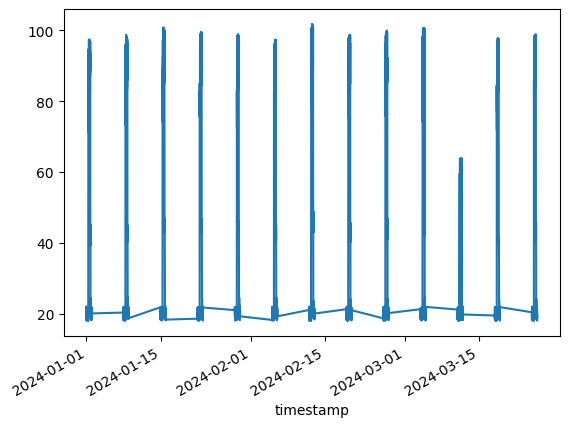

In [ ]:
plot_df(df_test_monday)

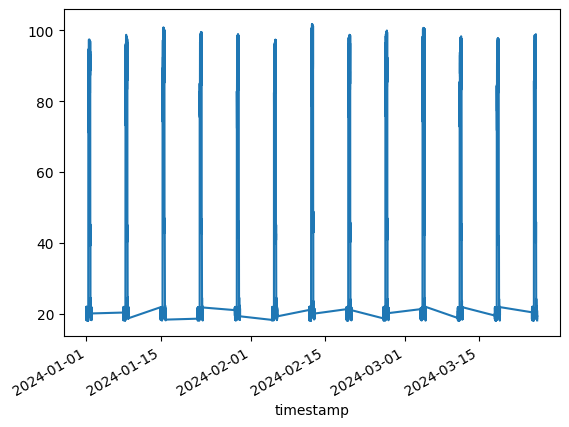

In [ ]:
plot_df(df_monday)

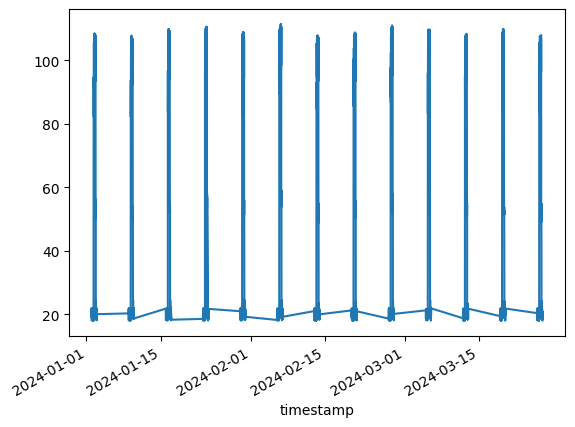

In [ ]:
plot_df(df_test_tuesday)

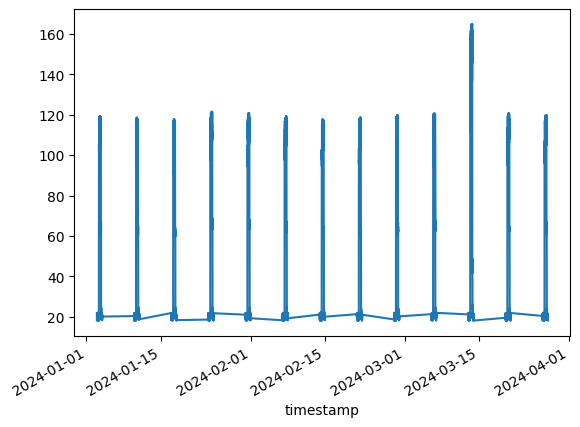

In [ ]:
plot_df(df_test_wednesday)

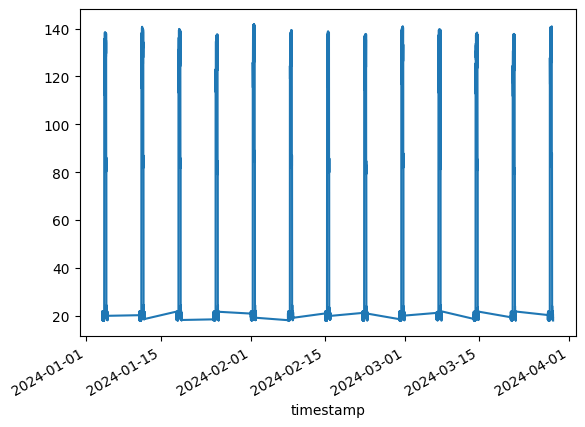

In [ ]:
plot_df(df_test_thursday)

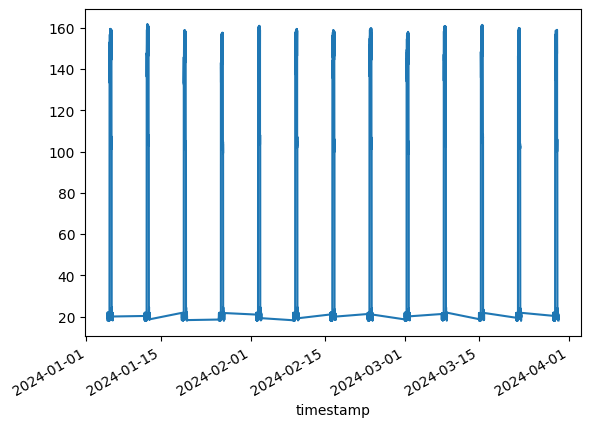

In [ ]:
plot_df(df_test_friday)

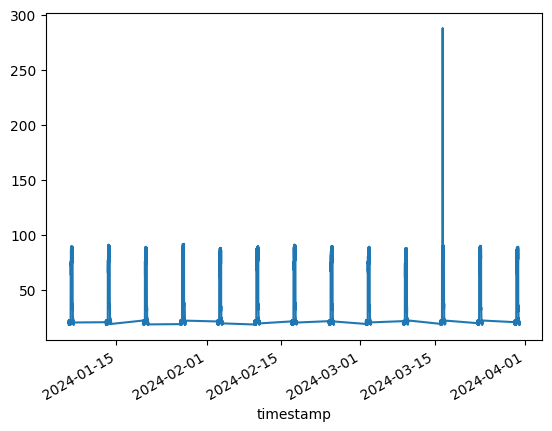

In [ ]:
plot_df(df_test_saturday)

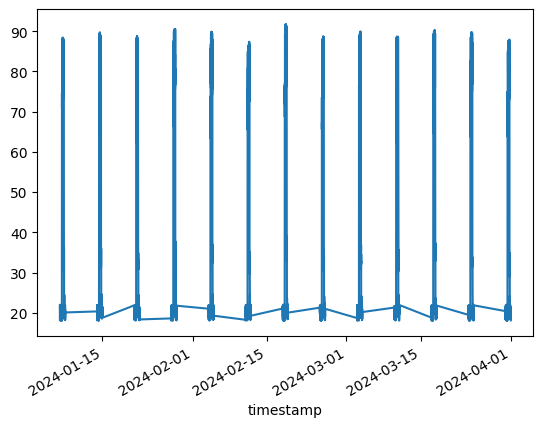

In [ ]:
plot_df(df_test_sunday)

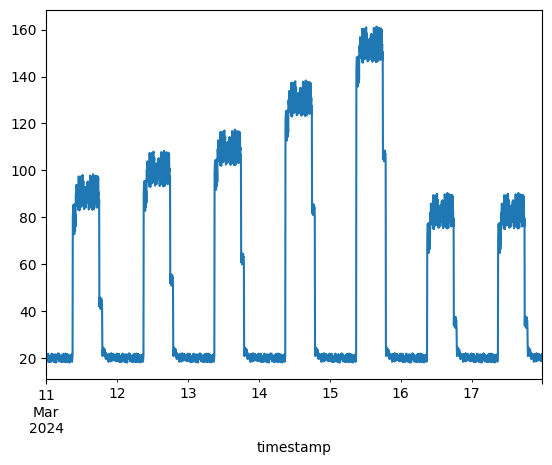

In [ ]:
plot_df(df_week)

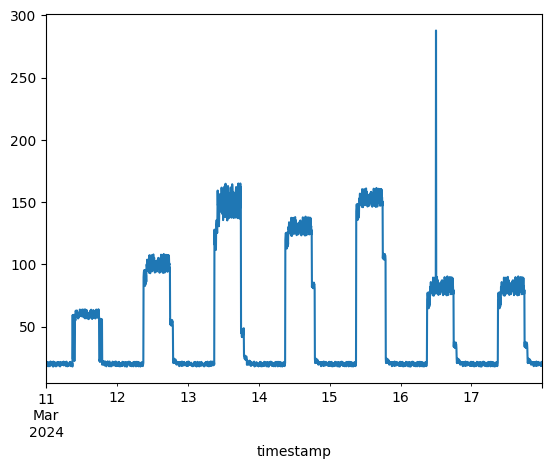

In [ ]:
plot_df(df_anomaly_week)

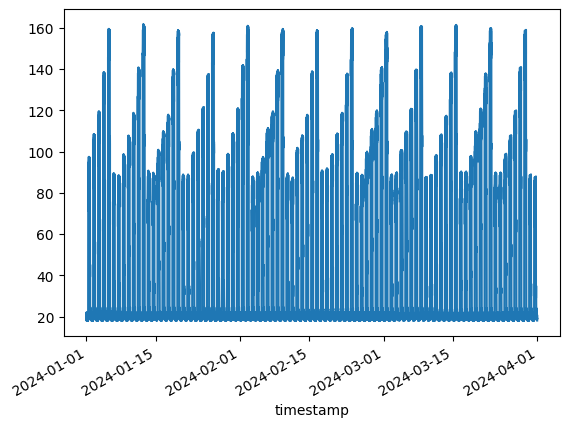

In [ ]:
plot_df(df_three_month)

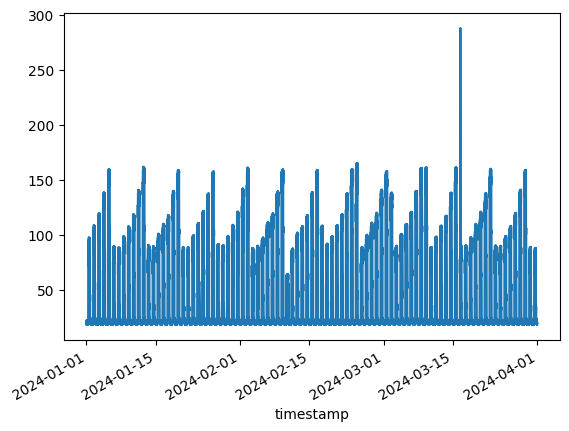

In [ ]:
plot_df(df_test_three_month)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTr  (None, 144, 16)           1808      
 anspose)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 288, 32)           3616      
 Transpose)                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 3s 119ms/step - loss: 0.2644 - val_loss: 0.0436
Epoch 3/50
25/25 [==============================] - 2s 61ms/step - loss: 0.0653 - val_loss: 0.0381
Epoch 4/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0520 - val_loss: 0.0341
Epoch 5/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0463 - val_loss: 0.0298
Epoch 6/50
25/25 [==============================] - 2s 60ms/step - loss: 0.0410 - val_loss: 0.0270
Epoch 7/50
25/25 [==============================] - 1s 59ms/step - loss: 0.0367 - val_loss: 0.0247
Epoch 8/50
25/25 [==============================] - 3s 106ms/step - loss: 0.0331 - val_loss: 0.0232
Epoch 9/50
25/25 [==============================] - 2s 78ms/step - loss: 0.0299 - val_loss: 0.0230
Epoch 10/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0280 - val_loss: 0.0219
Epoch 11/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0262 - val_loss: 0.0241
Epoch 12/50
25/25

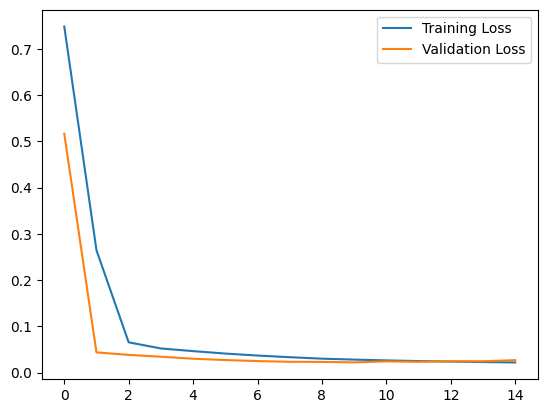

109/109 [==============================] - 1s 8ms/step


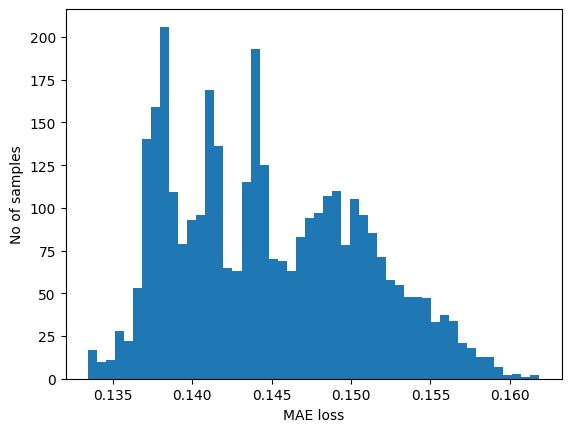

Reconstruction error threshold:  0.16184092896313704


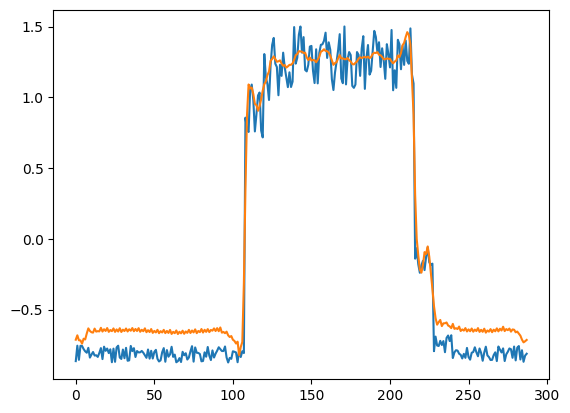

109/109 [==============================] - 1s 8ms/step


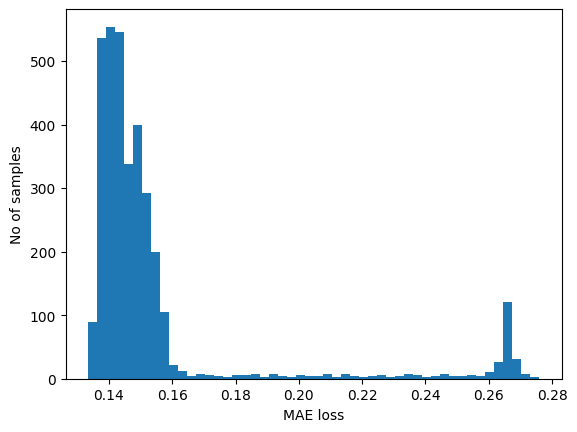

Number of anomaly samples:  374
Indices of anomaly samples:  (array([2710, 2711, 2713, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722,
       2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733,
       2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744,
       2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755,
       2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766,
       2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777,
       2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799,
       2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810,
       2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821,
       2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832,
       2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843,
       2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2

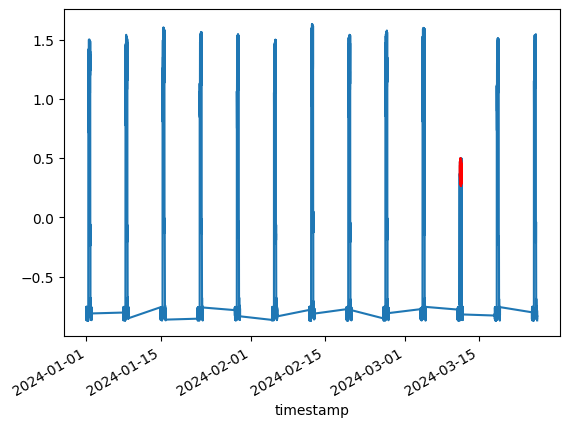

In [14]:
find_anomalies(df_monday, df_test_monday, 'models/monday.hdf5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1D  (None, 144, 16)           1808      
 Transpose)                                                      
                                                                 
 dropout_3 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1D  (None, 288, 32)           3616      
 Transpose)                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 1s 57ms/step - loss: 0.0877 - val_loss: 0.0423
Epoch 3/50
25/25 [==============================] - 2s 101ms/step - loss: 0.0576 - val_loss: 0.0319
Epoch 4/50
25/25 [==============================] - 2s 66ms/step - loss: 0.0471 - val_loss: 0.0263
Epoch 5/50
25/25 [==============================] - 2s 62ms/step - loss: 0.0394 - val_loss: 0.0219
Epoch 6/50
25/25 [==============================] - 2s 62ms/step - loss: 0.0343 - val_loss: 0.0193
Epoch 7/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0304 - val_loss: 0.0175
Epoch 8/50
25/25 [==============================] - 2s 68ms/step - loss: 0.0277 - val_loss: 0.0166
Epoch 9/50
25/25 [==============================] - 2s 61ms/step - loss: 0.0254 - val_loss: 0.0162
Epoch 10/50
25/25 [==============================] - 2s 87ms/step - loss: 0.0237 - val_loss: 0.0153
Epoch 11/50
25/25 [==============================] - 2s 82ms/step - loss: 0.0223 - val_loss: 0.0162
Epoch 12/50
25/25 

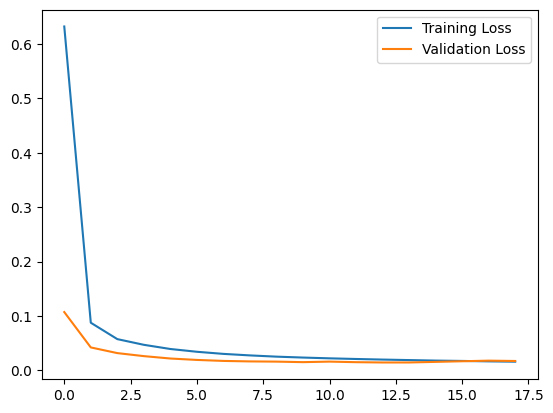

109/109 [==============================] - 1s 9ms/step


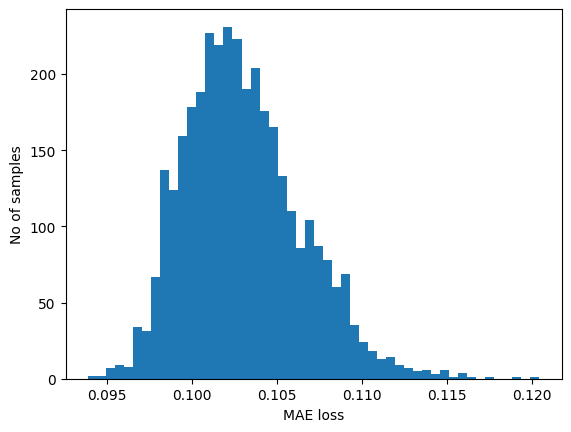

Reconstruction error threshold:  0.1204476572677971


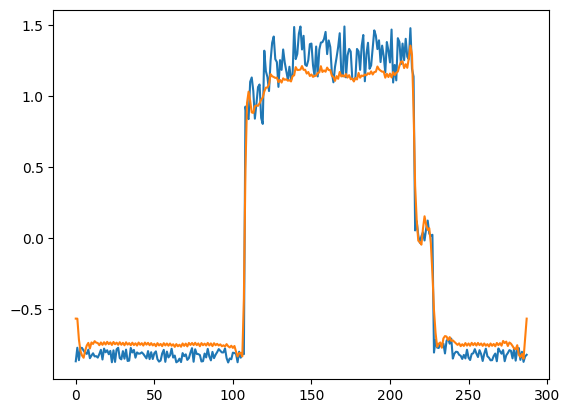

109/109 [==============================] - 1s 8ms/step


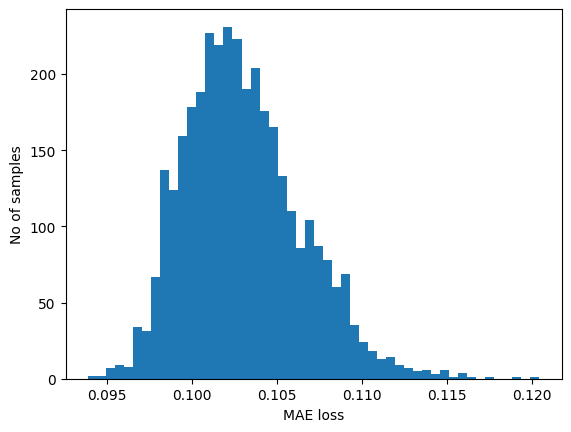

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)
No anomalies


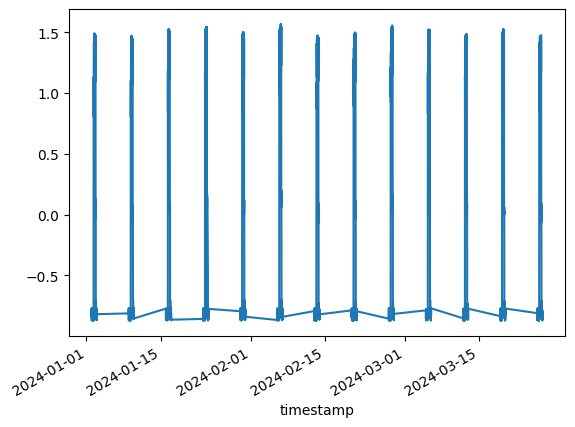

In [15]:
find_anomalies(df_tuesday, df_test_tuesday, 'models/tuesday.hdf5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_4 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_6 (Conv1D  (None, 144, 16)           1808      
 Transpose)                                                      
                                                                 
 dropout_5 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_7 (Conv1D  (None, 288, 32)           3616      
 Transpose)                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 65ms/step - loss: 0.0739 - val_loss: 0.0349
Epoch 3/50
25/25 [==============================] - 2s 60ms/step - loss: 0.0524 - val_loss: 0.0329
Epoch 4/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0449 - val_loss: 0.0277
Epoch 5/50
25/25 [==============================] - 2s 76ms/step - loss: 0.0390 - val_loss: 0.0239
Epoch 6/50
25/25 [==============================] - 2s 94ms/step - loss: 0.0332 - val_loss: 0.0203
Epoch 7/50
25/25 [==============================] - 2s 69ms/step - loss: 0.0286 - val_loss: 0.0182
Epoch 8/50
25/25 [==============================] - 2s 75ms/step - loss: 0.0256 - val_loss: 0.0173
Epoch 9/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0232 - val_loss: 0.0160
Epoch 10/50
25/25 [==============================] - 2s 62ms/step - loss: 0.0212 - val_loss: 0.0171
Epoch 11/50
25/25 [==============================] - 1s 60ms/step - loss: 0.0196 - val_loss: 0.0157
Epoch 12/50
25/25 [

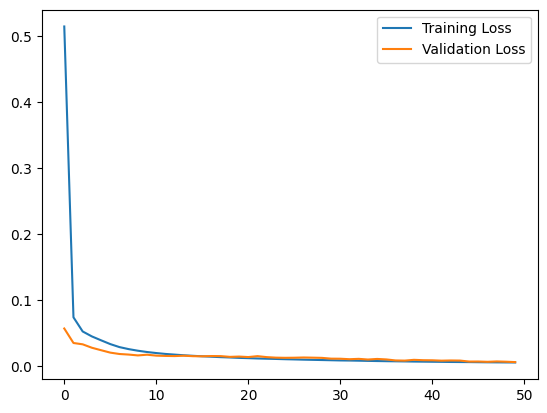

109/109 [==============================] - 1s 7ms/step


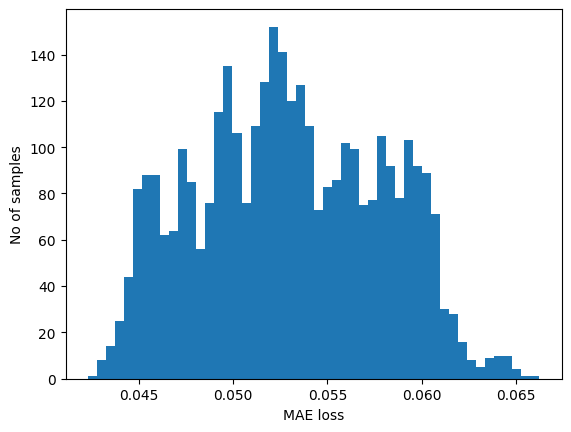

Reconstruction error threshold:  0.06624014198010918


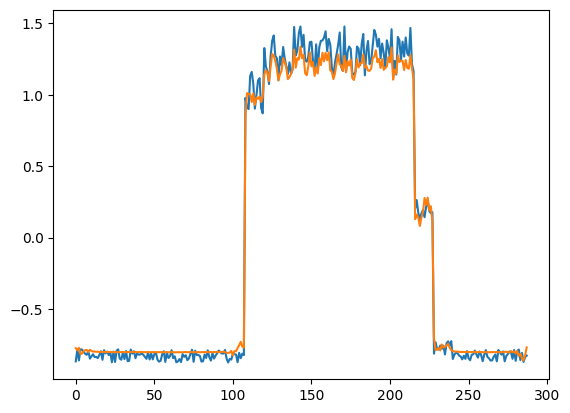

109/109 [==============================] - 1s 8ms/step


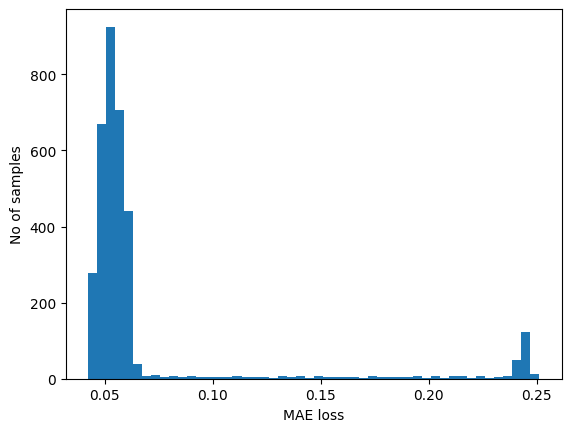

Number of anomaly samples:  396
Indices of anomaly samples:  (array([2699, 2701, 2702, 2703, 2707, 2709, 2710, 2711, 2712, 2713, 2714,
       2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725,
       2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736,
       2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747,
       2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758,
       2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769,
       2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780,
       2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791,
       2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802,
       2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813,
       2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824,
       2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835,
       2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2

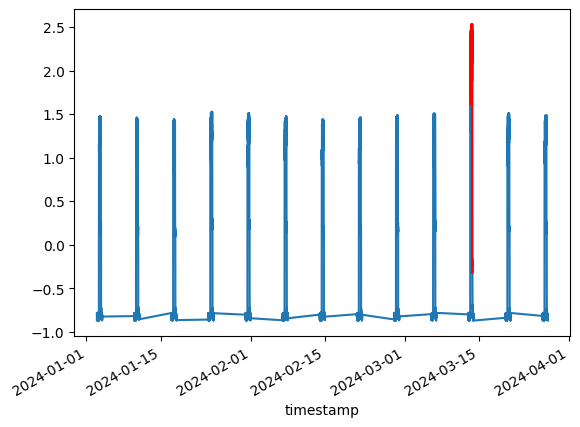

In [16]:
find_anomalies(df_wednesday, df_test_wednesday, 'models/wednesday.hdf5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_6 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_9 (Conv1D  (None, 144, 16)           1808      
 Transpose)                                                      
                                                                 
 dropout_7 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_10 (Conv1  (None, 288, 32)           3616      
 DTranspose)                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 68ms/step - loss: 0.0698 - val_loss: 0.0329
Epoch 3/50
25/25 [==============================] - 3s 109ms/step - loss: 0.0485 - val_loss: 0.0284
Epoch 4/50
25/25 [==============================] - 2s 62ms/step - loss: 0.0424 - val_loss: 0.0252
Epoch 5/50
25/25 [==============================] - 2s 60ms/step - loss: 0.0382 - val_loss: 0.0227
Epoch 6/50
25/25 [==============================] - 2s 62ms/step - loss: 0.0340 - val_loss: 0.0203
Epoch 7/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0303 - val_loss: 0.0185
Epoch 8/50
25/25 [==============================] - 2s 64ms/step - loss: 0.0269 - val_loss: 0.0167
Epoch 9/50
25/25 [==============================] - 1s 58ms/step - loss: 0.0239 - val_loss: 0.0147
Epoch 10/50
25/25 [==============================] - 2s 86ms/step - loss: 0.0217 - val_loss: 0.0135
Epoch 11/50
25/25 [==============================] - 2s 81ms/step - loss: 0.0199 - val_loss: 0.0136
Epoch 12/50
25/25 

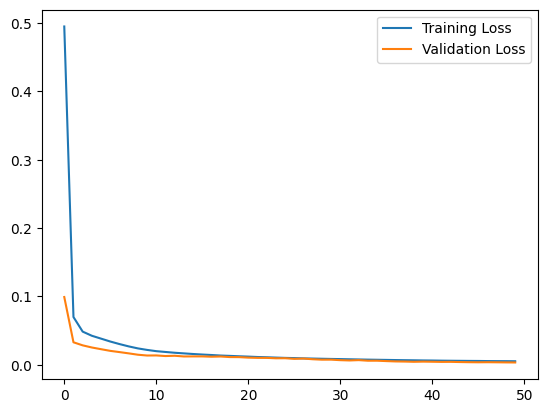

109/109 [==============================] - 1s 6ms/step


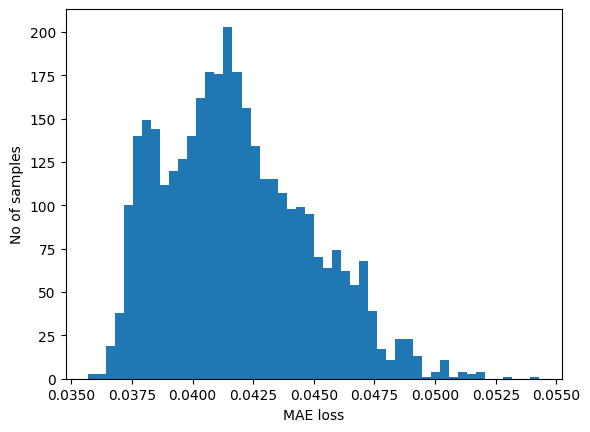

Reconstruction error threshold:  0.05428973332494047


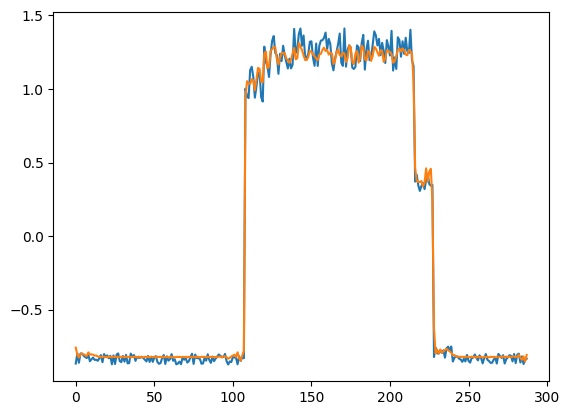

109/109 [==============================] - 1s 6ms/step


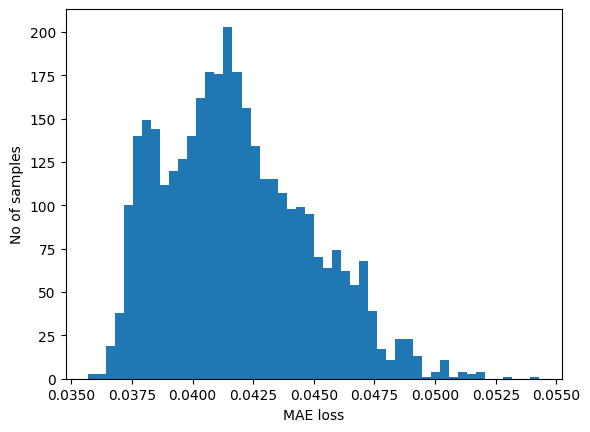

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)
No anomalies


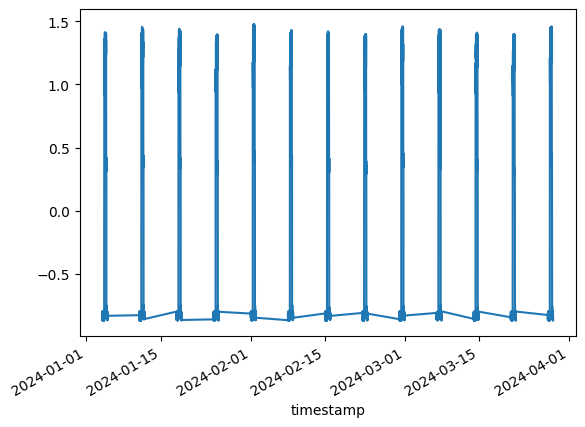

In [17]:
find_anomalies(df_thursday, df_test_thursday, 'models/thursday.hdf5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_8 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_12 (Conv1  (None, 144, 16)           1808      
 DTranspose)                                                     
                                                                 
 dropout_9 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_13 (Conv1  (None, 288, 32)           3616      
 DTranspose)                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 95ms/step - loss: 0.0758 - val_loss: 0.0310
Epoch 3/50
25/25 [==============================] - 2s 70ms/step - loss: 0.0506 - val_loss: 0.0274
Epoch 4/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0413 - val_loss: 0.0227
Epoch 5/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0350 - val_loss: 0.0193
Epoch 6/50
25/25 [==============================] - 2s 66ms/step - loss: 0.0298 - val_loss: 0.0164
Epoch 7/50
25/25 [==============================] - 2s 64ms/step - loss: 0.0264 - val_loss: 0.0154
Epoch 8/50
25/25 [==============================] - 2s 68ms/step - loss: 0.0235 - val_loss: 0.0147
Epoch 9/50
25/25 [==============================] - 3s 105ms/step - loss: 0.0215 - val_loss: 0.0139
Epoch 10/50
25/25 [==============================] - 2s 61ms/step - loss: 0.0198 - val_loss: 0.0137
Epoch 11/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0183 - val_loss: 0.0131
Epoch 12/50
25/25 

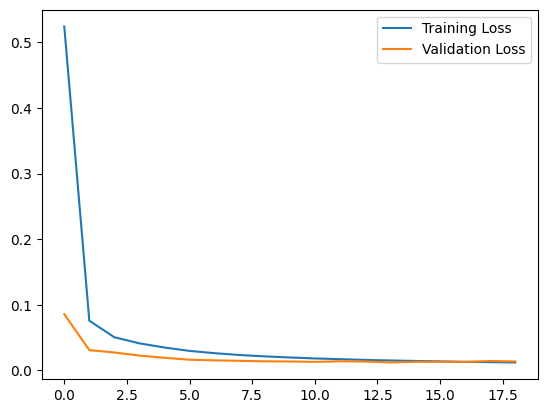

109/109 [==============================] - 1s 6ms/step


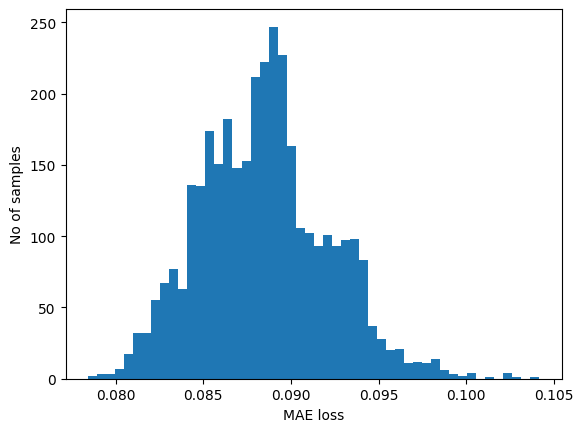

Reconstruction error threshold:  0.10415004883702021


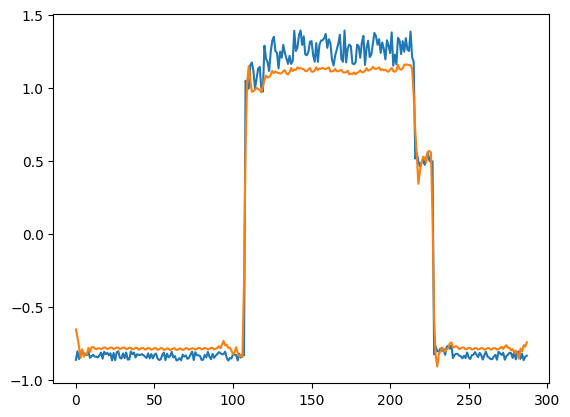

109/109 [==============================] - 1s 6ms/step


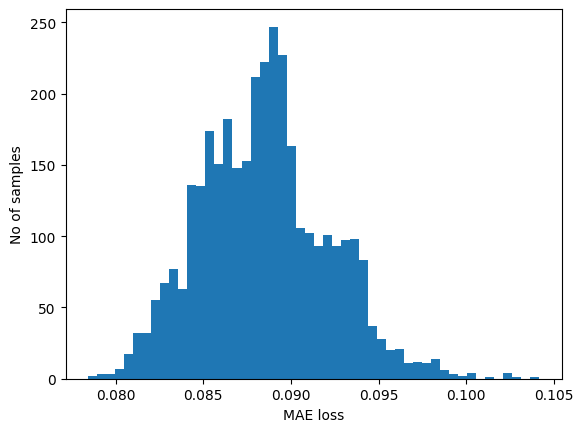

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)
No anomalies


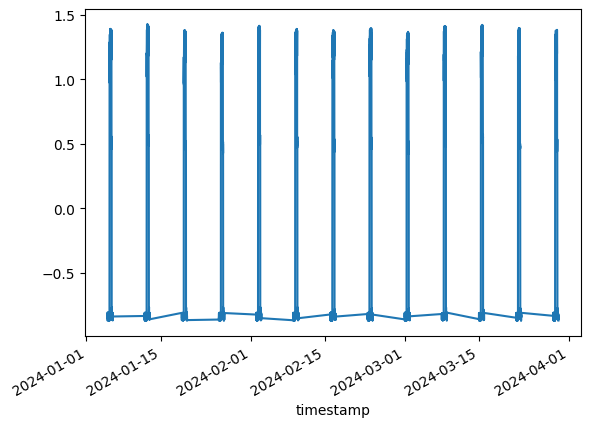

In [18]:
find_anomalies(df_friday, df_test_friday, 'models/friday.hdf5')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_10 (Dropout)        (None, 144, 32)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_15 (Conv1  (None, 144, 16)           1808      
 DTranspose)                                                     
                                                                 
 dropout_11 (Dropout)        (None, 144, 16)           0         
                                                                 
 conv1d_transpose_16 (Conv1  (None, 288, 32)           3616      
 DTranspose)                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 73ms/step - loss: 0.0755 - val_loss: 0.0417
Epoch 3/50
25/25 [==============================] - 1s 60ms/step - loss: 0.0539 - val_loss: 0.0321
Epoch 4/50
25/25 [==============================] - 1s 60ms/step - loss: 0.0445 - val_loss: 0.0289
Epoch 5/50
25/25 [==============================] - 1s 59ms/step - loss: 0.0386 - val_loss: 0.0257
Epoch 6/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0344 - val_loss: 0.0249
Epoch 7/50
25/25 [==============================] - 1s 60ms/step - loss: 0.0313 - val_loss: 0.0248
Epoch 8/50
25/25 [==============================] - 2s 68ms/step - loss: 0.0292 - val_loss: 0.0242
Epoch 9/50
25/25 [==============================] - 3s 101ms/step - loss: 0.0274 - val_loss: 0.0228
Epoch 10/50
25/25 [==============================] - 2s 64ms/step - loss: 0.0259 - val_loss: 0.0236
Epoch 11/50
25/25 [==============================] - 1s 59ms/step - loss: 0.0246 - val_loss: 0.0228
Epoch 12/50
25/25 

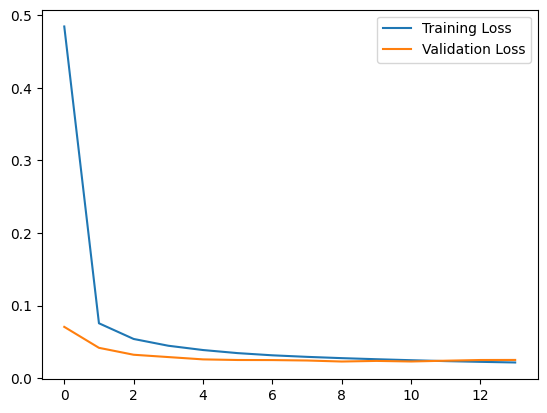

109/109 [==============================] - 1s 6ms/step


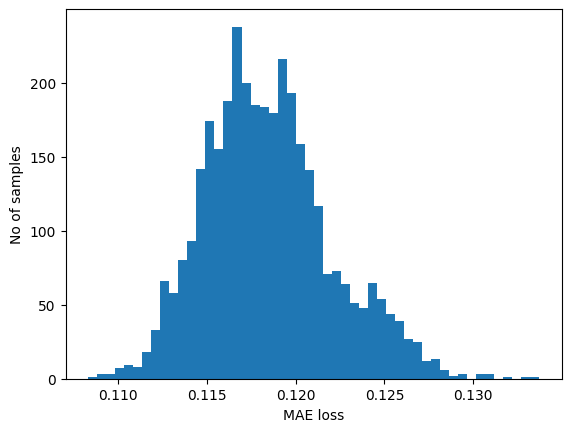

Reconstruction error threshold:  0.1337176156713314


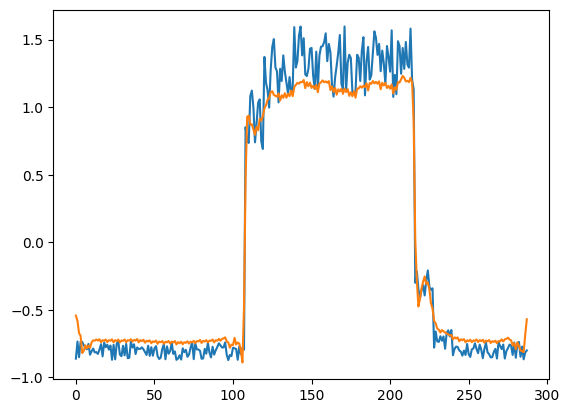

109/109 [==============================] - 1s 8ms/step


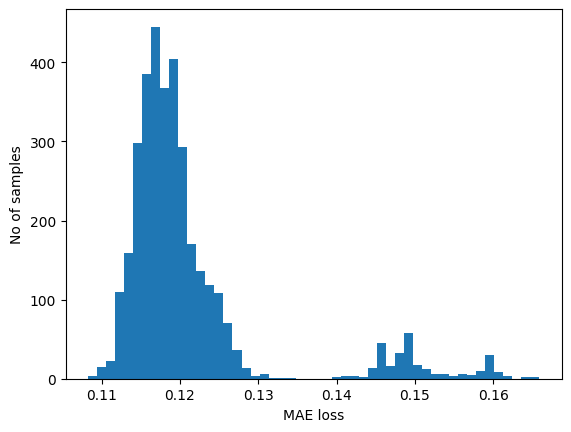

Number of anomaly samples:  288
Indices of anomaly samples:  (array([2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747,
       2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758,
       2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769,
       2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780,
       2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791,
       2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802,
       2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813,
       2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824,
       2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835,
       2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846,
       2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857,
       2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868,
       2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2

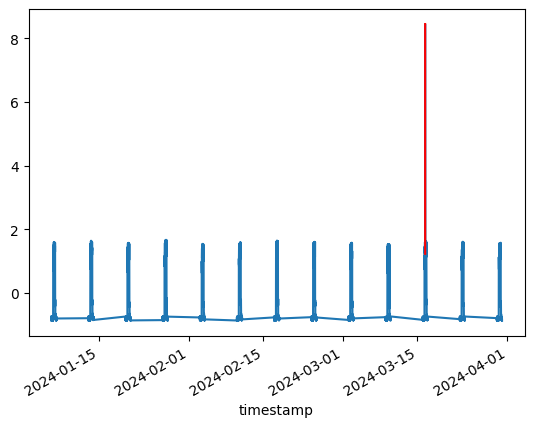

In [19]:
find_anomalies(df_saturday, df_test_saturday, 'models/saturday.hdf5')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_12 (Dropout)        (None, 144, 32)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_18 (Conv1  (None, 144, 16)           1808      
 DTranspose)                                                     
                                                                 
 dropout_13 (Dropout)        (None, 144, 16)           0         
                                                                 
 conv1d_transpose_19 (Conv1  (None, 288, 32)           3616      
 DTranspose)                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 3s 123ms/step - loss: 0.1839 - val_loss: 0.0395
Epoch 3/50
25/25 [==============================] - 2s 69ms/step - loss: 0.0603 - val_loss: 0.0358
Epoch 4/50
25/25 [==============================] - 2s 79ms/step - loss: 0.0465 - val_loss: 0.0300
Epoch 5/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0389 - val_loss: 0.0284
Epoch 6/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0343 - val_loss: 0.0276
Epoch 7/50
25/25 [==============================] - 1s 57ms/step - loss: 0.0313 - val_loss: 0.0292
Epoch 8/50
25/25 [==============================] - 1s 57ms/step - loss: 0.0289 - val_loss: 0.0312
Epoch 9/50
25/25 [==============================] - 3s 103ms/step - loss: 0.0271 - val_loss: 0.0315
Epoch 10/50
25/25 [==============================] - 2s 74ms/step - loss: 0.0257 - val_loss: 0.0330
Epoch 11/50
25/25 [==============================] - 2s 64ms/step - loss: 0.0245 - val_loss: 0.0328


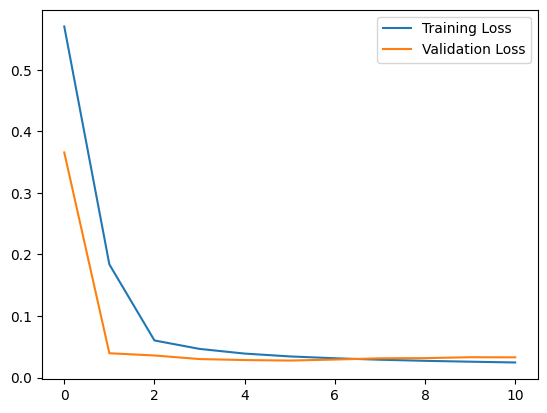

109/109 [==============================] - 1s 8ms/step


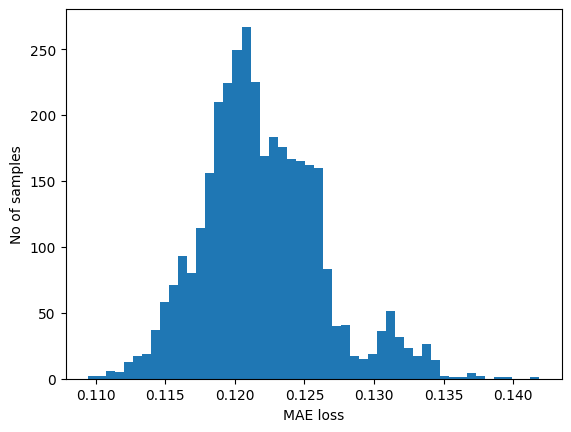

Reconstruction error threshold:  0.14185476502030953


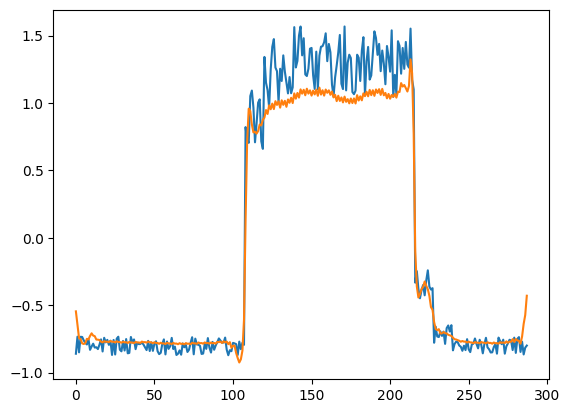

109/109 [==============================] - 1s 8ms/step


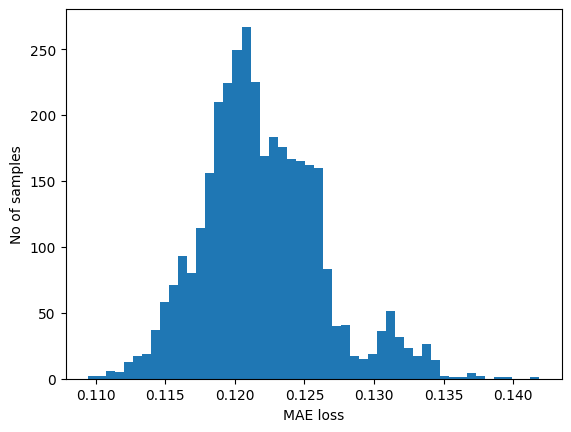

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)
No anomalies


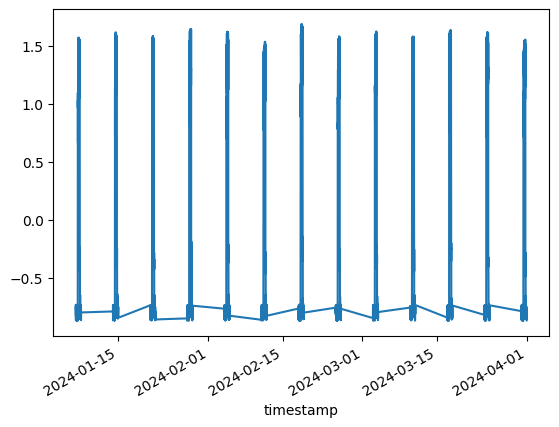

In [20]:
find_anomalies(df_sunday, df_test_sunday, 'models/sunday.hdf5')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_14 (Dropout)        (None, 144, 32)           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_21 (Conv1  (None, 144, 16)           1808      
 DTranspose)                                                     
                                                                 
 dropout_15 (Dropout)        (None, 144, 16)           0         
                                                                 
 conv1d_transpose_22 (Conv1  (None, 288, 32)           3616      
 DTranspose)                                          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


183/183 [==============================] - 13s 72ms/step - loss: 0.0223 - val_loss: 0.0101
Epoch 3/50
183/183 [==============================] - 13s 70ms/step - loss: 0.0151 - val_loss: 0.0097
Epoch 4/50
183/183 [==============================] - 13s 73ms/step - loss: 0.0122 - val_loss: 0.0094
Epoch 5/50
183/183 [==============================] - 13s 71ms/step - loss: 0.0104 - val_loss: 0.0089
Epoch 6/50
183/183 [==============================] - 13s 73ms/step - loss: 0.0091 - val_loss: 0.0080
Epoch 7/50
183/183 [==============================] - 13s 71ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 8/50
183/183 [==============================] - 13s 71ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 9/50
183/183 [==============================] - 13s 72ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 10/50
183/183 [==============================] - 13s 74ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 11/50
183/183 [==============================] - 13s 71ms/step - loss: 0.0061 - val_lo

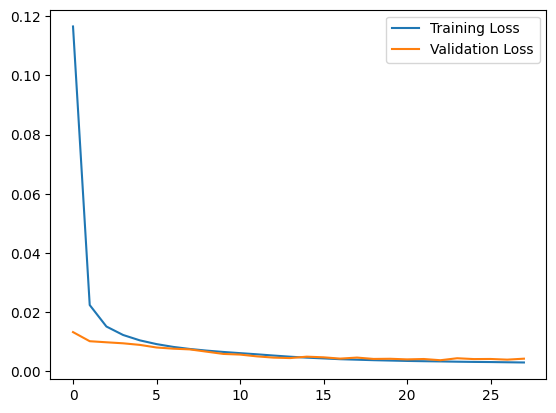

811/811 [==============================] - 7s 9ms/step


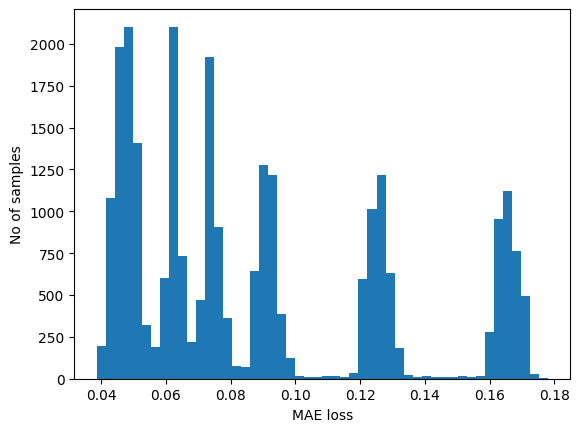

Reconstruction error threshold:  0.1779646819345075


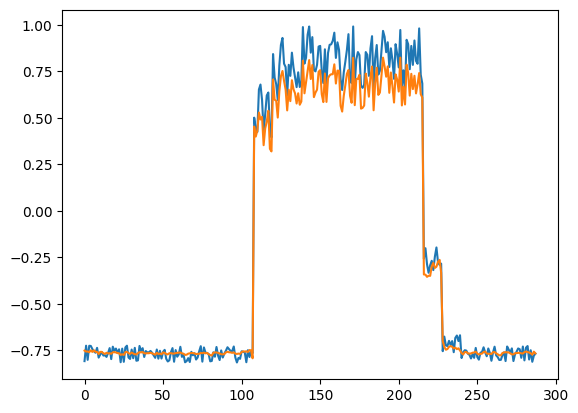

811/811 [==============================] - 5s 6ms/step


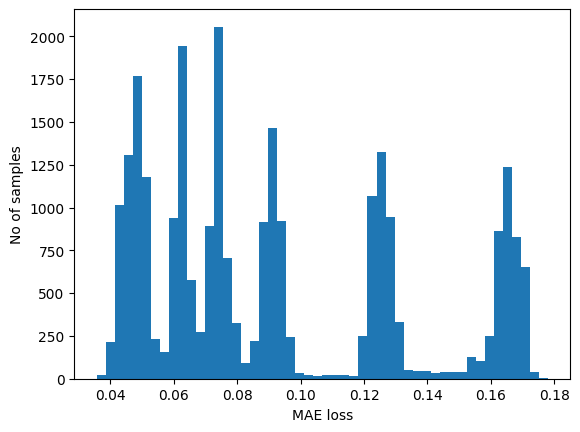

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)
No anomalies


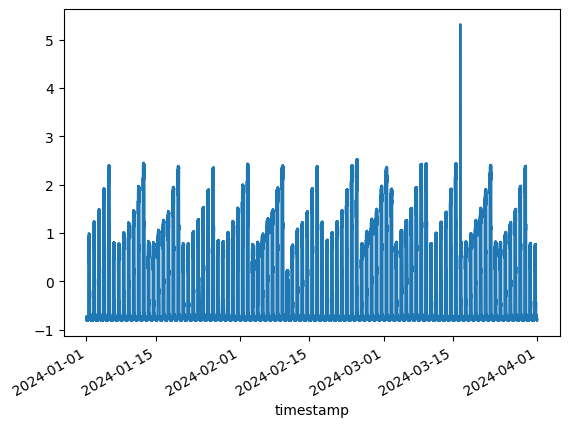

In [21]:
find_anomalies(df_three_month, df_test_three_month, 'models/three_month.hdf5')